# Original

In [ ]:
def _distributed_access(g, nodes, issue_remote_req, local_access):
  req_list = []
  partition_book = g.get_partition_book()
  nodes = toindex(nodes).tousertensor()
  partition_id = partition_book.nid2partid(nodes)
  local_nids = None
  # Go around every partition
  for pid in range(partition_book.num_partitions()):
    node_id = F.boolean_mask(nodes, partition_id == pid)
    if pid == partition_book.partid and g.local_partition is not None:
      assert local_nids is None
      local_nids = node_id
    elif len(node_id) != 0:
      req = issue_remote_req(node_id)
      req_list.append((pid, req))
  
  # send requests to the remote machine.
  msgseq2pos = None
  if len(req_list) > 0:
    msgseq2pos = send_requests_to_machine(req_list)

  # sample neighbors for the nodes in the local partition.
  res_list = []
  if local_nids is not None:
    src, dst, eids = local_access(g.local_partition, partition_book, local_nids)
    res_list.append(LocalSampledGraph(src, dst, eids))

  # receive responses from remote machines.
  if msgseq2pos is not None:
    results = recv_responses(msgseq2pos)
    res_list.extend(results)

  sampled_graph = merge_graphs(res_list, g.number_of_nodes())
  return sampled_graph

# Modified

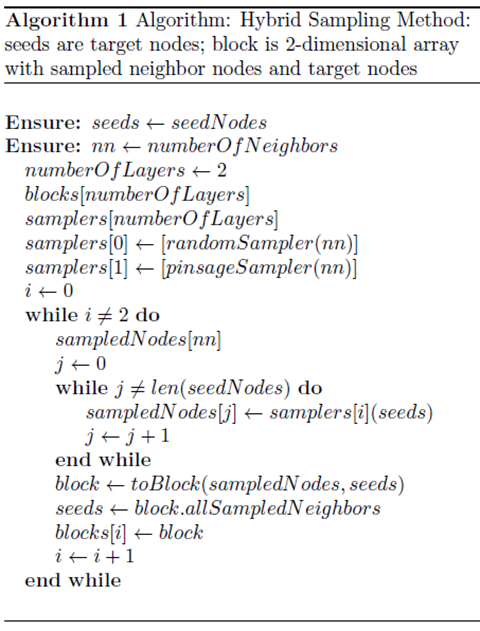

## NeighborSampler

In [ ]:
class NeighborSampler(object):
    def __init__(self, g, fanouts, sample_neighbors, device, load_feat=True):
        self.g = g
        self.fanouts = fanouts
        self.sample_neighbors = sample_neighbors
        self.device = device
        self.load_feat = load_feat

    def sample_blocks(self, seeds):
        seeds = th.LongTensor(np.asarray(seeds))
        blocks = []
        presampled_list = []
        for fanout in self.fanouts:
            # For each seed node, sample ``fanout`` neighbors.
            frontier, presampled_list = self.sample_neighbors(
                self.g, seeds, presampled_list, fanout, replace=True
            )
            # Then we compact the frontier into a bipartite graph for message passing.
            block = dgl.to_block(frontier, seeds)
            # Obtain the seed nodes for next layer.
            seeds = block.srcdata[dgl.NID]

            blocks.insert(0, block)

        input_nodes = blocks[0].srcdata[dgl.NID]
        seeds = blocks[-1].dstdata[dgl.NID]
        batch_inputs, batch_labels = load_subtensor(
            self.g, seeds, input_nodes, "cpu", self.load_feat
        )
        if self.load_feat:
            blocks[0].srcdata["features"] = batch_inputs
        blocks[-1].dstdata["labels"] = batch_labels
        return blocks


In [ ]:
class NeighborSampler(object):
    def __init__(self, g, fanouts, sample_neighbors, device, load_feat=True):
        self.g = g
        self.fanouts = fanouts
        self.sample_neighbors = sample_neighbors
        self.device = device
        self.load_feat = load_feat

    def sample_blocks(self, seeds):
        seeds = th.LongTensor(np.asarray(seeds))
        blocks = []
        frontiers = self.sample_neighbors_atonce(
                self.g, seeds, self.fanouts, replace=True
        )
        for frontier in frontiers:
          block = dgl.to_block(frontier, seeds)
          seeds = block.srcdata[dgl.NID]
          blocks.insert(0, block)


        # for fanout in self.fanouts:
        #     # For each seed node, sample ``fanout`` neighbors.
        #     frontier, presampled_list = self.sample_neighbors(
        #         self.g, seeds, presampled_list, fanout, replace=True
        #     )
        #     # Then we compact the frontier into a bipartite graph for message passing.
        #     block = dgl.to_block(frontier, seeds)
        #     # Obtain the seed nodes for next layer.
        #     seeds = block.srcdata[dgl.NID]

        #     blocks.insert(0, block)

        input_nodes = blocks[0].srcdata[dgl.NID]
        seeds = blocks[-1].dstdata[dgl.NID]
        batch_inputs, batch_labels = load_subtensor(
            self.g, seeds, input_nodes, "cpu", self.load_feat
        )
        if self.load_feat:
            blocks[0].srcdata["features"] = batch_inputs
        blocks[-1].dstdata["labels"] = batch_labels
        return blocks


## sampling_neighbors

In [ ]:
def sample_neighbors(g, nodes, presampled_list, fanout, edge_dir='in', prob=None, replace=False):
  gpb = g.get_partition_book()
  if not gpb.is_homogeneous:
      assert isinstance(nodes, dict)
      homo_nids = []
      for ntype in nodes:
          assert ntype in g.ntypes, 'The sampled node type does not exist in the input graph'
          if F.is_tensor(nodes[ntype]):
              typed_nodes = nodes[ntype]
          else:
              typed_nodes = toindex(nodes[ntype]).tousertensor()
          homo_nids.append(gpb.map_to_homo_nid(typed_nodes, ntype))
      nodes = F.cat(homo_nids, 0)
  elif isinstance(nodes, dict):
      assert len(nodes) == 1
      nodes = list(nodes.values())[0]

  def issue_remote_req(node_ids):
      return SamplingRequest(node_ids, fanout, edge_dir=edge_dir,
                              prob=prob, replace=replace)
  def local_access(local_g, partition_book, local_nids):
      return _sample_neighbors(local_g, partition_book, local_nids,
                                fanout, edge_dir, prob, replace)
  frontier, presampled_list = _distributed_access(g, nodes, presampled_list, issue_remote_req, local_access)
  
  if not gpb.is_homogeneous:
      return _frontier_to_heterogeneous_graph(g, frontier, gpb), presampled_list
  else:
      return frontier, presampled_list

In [ ]:
def sample_neighbors_atonce(g, nodes, fanouts, edge_dir='in', prob=None, replace=False):
  gpb = g.get_partition_book()
  if not gpb.is_homogeneous:
      assert isinstance(nodes, dict)
      homo_nids = []
      for ntype in nodes:
          assert ntype in g.ntypes, 'The sampled node type does not exist in the input graph'
          if F.is_tensor(nodes[ntype]):
              typed_nodes = nodes[ntype]
          else:
              typed_nodes = toindex(nodes[ntype]).tousertensor()
          homo_nids.append(gpb.map_to_homo_nid(typed_nodes, ntype))
      nodes = F.cat(homo_nids, 0)
  elif isinstance(nodes, dict):
      assert len(nodes) == 1
      nodes = list(nodes.values())[0]

  def issue_remote_req(node_ids):
      return SamplingRequest(node_ids, fanout, edge_dir=edge_dir,
                              prob=prob, replace=replace)
  def local_access(local_g, partition_book, local_nids):
      return _sample_neighbors(local_g, partition_book, local_nids,
                                fanout, edge_dir, prob, replace)
  frontiers = _distributed_access_atonce(g, nodes, fanouts, issue_remote_req, local_access)
  
  if not gpb.is_homogeneous:
    frontiers_heterogeneous = []
    for frontier in frontiers:
      frontier = _frontier_to_heterogeneous_graph(g, frontier, gpb)
      frontiers_heterogeneous.append(frontier)
    return frontiers_heterogeneous
  else:
      return frontiers

## SamplingRequest

In [ ]:
class SamplingRequest(Request):
    """Sampling Request"""

    def __init__(self, nodes, fan_out, edge_dir='in', prob=None, replace=False):
        self.seed_nodes = nodes
        self.edge_dir = edge_dir
        self.prob = prob
        self.replace = replace
        self.fan_out = fan_out

    def __setstate__(self, state):
        self.seed_nodes, self.edge_dir, self.prob, self.replace, self.fan_out = state

    def __getstate__(self):
        return self.seed_nodes, self.edge_dir, self.prob, self.replace, self.fan_out

    def process_request(self, server_state):
        local_g = server_state.graph
        partition_book = server_state.partition_book

        # first sampling
        global_src, global_dst, global_eids = _sample_neighbors(local_g, partition_book,
                                                                self.seed_nodes,
                                                                self.fan_out, self.edge_dir,
                                                                self.prob, self.replace)
        # Added code section
        # second sampling for dst_nodes of next layer
        presampled = []
        if len(global_eids) !=0:
          presampling_targets = []
          for eid_tuple in global_eids:
            presampling_targets.append(eid_tuple[1])
          
          presampling_targets = toindex(presampling_targets).tousertensor()
          partition_id = partition_book.nid2partid(presampling_targets)
          target_ids = F.boolean_mask(presampling_targets, partition_id == partition_book.partid)

          # presampling for next layer
          if len(target_ids) != 0:
            presampled_global_src, presampled_global_dst, presampled_global_eids = _sample_neighbors(local_g, partition_book,
                                                                    self.target_ids,
                                                                    self.fan_out, self.edge_dir,
                                                                    self.prob, self.replace)
        
        return [SubgraphResponse(global_src, global_dst, global_eids), SubgraphResponse(presampled_global_src, presampled_global_dst, presampled_global_eids)]

## _distributed_access

In [ ]:
def _distributed_access(g, nodes, presampled_list, issue_remote_req, local_access):
  req_list = []
  res_list = []

  partition_book = g.get_partition_book()
  nodes = toindex(nodes).tousertensor()
  partition_id = partition_book.nid2partid(nodes)
  local_nids = None

  # if we have presampled responses then true
  presampled_flag = len(presampled_list)! = 0
  if presampled_flag:
    res_list.extend(presampled_list)

  # Go around every partition
  for pid in range(partition_book.num_partitions()):
    node_id = F.boolean_mask(nodes, partition_id == pid)
    if pid == partition_book.partid and g.local_partition is not None:
      assert local_nids is None
      local_nids = node_id
    elif len(node_id) != 0 and !presampled_flag:
      req = issue_remote_req(node_id)
      req_list.append((pid, req))
  
  # send requests to the remote machine.
  msgseq2pos = None
  if len(req_list) > 0:
    msgseq2pos = send_requests_to_machine(req_list)

  # sample neighbors for the nodes in the local partition.
  
  presampled_list = []

  if local_nids is not None:
    src, dst, eids = local_access(g.local_partition, partition_book, local_nids)
    res_list.append(LocalSampledGraph(src, dst, eids))

  # receive responses from remote machines.
  if msgseq2pos is not None:
    results = recv_responses(msgseq2pos)
    res_list.extend(results[0])
    presampled_list.extend(results[1])


  sampled_graph = merge_graphs(res_list, g.number_of_nodes())
  return sampled_graph, presampled_list

In [ ]:
def _distributed_access_atonce(g, nodes, fanouts, issue_remote_req, local_access):
  frontiers = []
  for fanout in fanouts:
    req_list = []
    partition_book = g.get_partition_book()
    nodes = toindex(nodes).tousertensor()
    partition_id = partition_book.nid2partid(nodes)
    local_nids = None
    # Go around every partition
    for pid in range(partition_book.num_partitions()):
      node_id = F.boolean_mask(nodes, partition_id == pid)
      if pid == partition_book.partid and g.local_partition is not None:
        assert local_nids is None
        local_nids = node_id
      elif len(node_id) != 0:
        req = issue_remote_req(node_id)
        req_list.append((pid, req))
    
    # send requests to the remote machine.
    msgseq2pos = None
    if len(req_list) > 0:
      msgseq2pos = send_requests_to_machine(req_list)

    # sample neighbors for the nodes in the local partition.
    res_list = []
    if local_nids is not None:
      src, dst, eids = local_access(g.local_partition, partition_book, local_nids)
      res_list.append(LocalSampledGraph(src, dst, eids))

    # receive responses from remote machines.
    if msgseq2pos is not None:
      results = recv_responses(msgseq2pos)
      res_list.extend(results)

    sampled_graph = merge_graphs(res_list, g.number_of_nodes())
    frontiers.append(sampled_graph)
  return frontiers

#atonce

In [ ]:
# modified code############################################################
def sample_neighbors_atonce(g, nodes, fanouts, edge_dir='in', prob=None, replace=False):
    
    gpb = g.get_partition_book()
    if not gpb.is_homogeneous:
        assert isinstance(nodes, dict)
        homo_nids = []
        for ntype in nodes:
            assert ntype in g.ntypes, 'The sampled node type does not exist in the input graph'
            if F.is_tensor(nodes[ntype]):
                typed_nodes = nodes[ntype]
            else:
                typed_nodes = toindex(nodes[ntype]).tousertensor()
            homo_nids.append(gpb.map_to_homo_nid(typed_nodes, ntype))
        nodes = F.cat(homo_nids, 0)
    elif isinstance(nodes, dict):
        assert len(nodes) == 1
        nodes = list(nodes.values())[0]

    
    frontiers = []
    seed_nodes = nodes
    for fanout in fanouts:
      def issue_remote_req(node_ids):
        return SamplingRequest(node_ids, fanout, edge_dir=edge_dir,
                              prob=prob, replace=replace)
      def local_access(local_g, partition_book, local_nids):
        return _sample_neighbors(local_g, partition_book, local_nids,
                                      fanout, edge_dir, prob, replace)
      frontier = _distributed_access(g, seed_nodes, issue_remote_req, local_access)
      if not gpb.is_homogeneous:
          frontiers.append(_frontier_to_heterogeneous_graph(g, frontier, gpb))
      else:
          frontiers.append(frontier)
      seed_nodes = frontier.all_edges()[0]
    return frontiers

def _distributed_access(g, nodes, issue_remote_req, local_access):
    '''A routine that fetches local neighborhood of nodes from the distributed graph.

    The local neighborhood of some nodes are stored in the local machine and the other
    nodes have their neighborhood on remote machines. This code will issue remote
    access requests first before fetching data from the local machine. In the end,
    we combine the data from the local machine and remote machines.
    In this way, we can hide the latency of accessing data on remote machines.

    Parameters
    ----------
    g : DistGraph
        The distributed graph
    nodes : tensor
        The nodes whose neighborhood are to be fetched.
    issue_remote_req : callable
        The function that issues requests to access remote data.
    local_access : callable
        The function that reads data on the local machine.

    Returns
    -------
    DGLHeteroGraph
        The subgraph that contains the neighborhoods of all input nodes.
    '''
    req_list = []
    partition_book = g.get_partition_book()
    nodes = toindex(nodes).tousertensor()
    partition_id = partition_book.nid2partid(nodes)
    local_nids = None
    for pid in range(partition_book.num_partitions()):
        node_id = F.boolean_mask(nodes, partition_id == pid)
        # We optimize the sampling on a local partition if the server and the client
        # run on the same machine. With a good partitioning, most of the seed nodes
        # should reside in the local partition. If the server and the client
        # are not co-located, the client doesn't have a local partition.
        if pid == partition_book.partid and g.local_partition is not None:
            assert local_nids is None
            local_nids = node_id
        elif len(node_id) != 0:
            # print("length of node_id: ",len(node_id),"- remote req is issued@@@@@@@@@@@@@@@@@@@")
            # print("partition_id: ",partition_id,", pid: ",pid)
            # print("node_id: ",node_id)
            req = issue_remote_req(node_id)
            req_list.append((pid, req))

    # send requests to the remote machine.
    msgseq2pos = None
    if len(req_list) > 0:
        msgseq2pos = send_requests_to_machine(req_list)

    # sample neighbors for the nodes in the local partition.
    res_list = []
    if local_nids is not None:
        src, dst, eids = local_access(g.local_partition, partition_book, local_nids)
        local_sampled_graph = LocalSampledGraph(src, dst, eids)
        res_list.append(local_sampled_graph)
        # print("LocalSampledGraph dst: ",local_sampled_graph[1])
    
    # receive responses from remote machines.
    if msgseq2pos is not None:
        results = recv_responses(msgseq2pos)
        res_list.extend(results)

    sampled_graph = merge_graphs(res_list, g.number_of_nodes())
    return sampled_graph

In [ ]:
class NeighborSampler_atonce(object):
    def __init__(self, g, fanouts, sample_neighbors_atonce, device, load_feat=True):
        self.g = g
        self.fanouts = fanouts
        self.sample_neighbors_atonce = sample_neighbors_atonce
        self.device = device
        self.load_feat = load_feat

    def sample_blocks(self, seeds):
        seeds = th.LongTensor(np.asarray(seeds))
        blocks = []
        frontiers = self.sample_neighbors_atonce(
                self.g, seeds, self.fanouts, replace=True
        )
        for frontier in frontiers:
          block = dgl.to_block(frontier, seeds)
          seeds = block.srcdata[dgl.NID]
          blocks.insert(0, block)

        input_nodes = blocks[0].srcdata[dgl.NID]
        seeds = blocks[-1].dstdata[dgl.NID]
        batch_inputs, batch_labels = load_subtensor(
            self.g, seeds, input_nodes, "cpu", self.load_feat
        )
        if self.load_feat:
            blocks[0].srcdata["features"] = batch_inputs
        blocks[-1].dstdata["labels"] = batch_labels
        return blocks

In [ ]:
def sample_neighbors_atonce(g, nodes, fanouts, edge_dir='in', prob=None, replace=False):
    
    gpb = g.get_partition_book()
    if not gpb.is_homogeneous:
        assert isinstance(nodes, dict)
        homo_nids = []
        for ntype in nodes:
            assert ntype in g.ntypes, 'The sampled node type does not exist in the input graph'
            if F.is_tensor(nodes[ntype]):
                typed_nodes = nodes[ntype]
            else:
                typed_nodes = toindex(nodes[ntype]).tousertensor()
            homo_nids.append(gpb.map_to_homo_nid(typed_nodes, ntype))
        nodes = F.cat(homo_nids, 0)
    elif isinstance(nodes, dict):
        assert len(nodes) == 1
        nodes = list(nodes.values())[0]

    def issue_remote_reqs(node_ids):
        return SamplingRequestsAtOnce(node_ids, fanouts, edge_dir=edge_dir,
                                prob=prob, replace=replace), 
    def local_access_atonce(local_g, partition_book, local_nids_list):
        local_sample_neighbrs_list = []
        for i, local_nids in enumerate(local_nids_list):
          local_sample_neighbrs_list.append(
              _sample_neighbors(local_g, partition_book, local_nids,
                                    fanouts[i], edge_dir, prob, replace))
          
        return local_sample_neighbrs_list
    
    frontiers = _distributed_access_atonce(g, seed_nodes, issue_remote_reqs, local_access_atonce)
    
    heterogeneous_frontiers = []
        if not gpb.is_homogeneous:
          for frontier in frontiers:
            heterogeneous_frontiers.append(_frontier_to_heterogeneous_graph(g, frontier, gpb))
          return heterogeneous_frontiers

    return frontiers

In [ ]:
def _distributed_access_atonce(g, seed_nodes, issue_remote_reqs, local_access_atonce):
  req_list = []
  partition_book = g.get_partition_book()
  nodes = toindex(nodes).tousertensor()
  partition_id = partition_book.nid2partid(nodes)
  local_nids = None
  # Go around every partition
  for pid in range(partition_book.num_partitions()):
    node_id = F.boolean_mask(nodes, partition_id == pid)
    if pid == partition_book.partid and g.local_partition is not None:
      assert local_nids is None
      local_nids = node_id
    elif len(node_id) != 0:
      req = issue_remote_req(node_id)
      req_list.append((pid, req))
  
  # send requests to the remote machine.
  msgseq2pos = None
  if len(req_list) > 0:
    msgseq2pos = send_requests_to_machine(req_list)

  # sample neighbors for the nodes in the local partition.
  res_list = []
  if local_nids is not None:
    src, dst, eids = local_access(g.local_partition, partition_book, local_nids)
    res_list.append(LocalSampledGraph(src, dst, eids))

  # receive responses from remote machines.
  if msgseq2pos is not None:
    results = recv_responses(msgseq2pos)
    res_list.extend(results)

  sampled_graph = merge_graphs(res_list, g.number_of_nodes())
  return sampled_graph

#NeighborSamplerPlus

## Origin sample_blocks

In [ ]:
def sample_blocks(self, seeds):
  seeds = th.LongTensor(np.asarray(seeds))
  blocks = []
  for fanout in self.fanouts:
      # For each seed node, sample ``fanout`` neighbors.
      
      frontier = self.sample_neighbors(
          self.g, seeds, fanout, replace=True
      )
      # Then we compact the frontier into a bipartite graph for message passing.
      block = dgl.to_block(frontier, seeds)
      # Obtain the seed nodes for next layer.
      seeds = block.srcdata[dgl.NID]
      blocks.insert(0, block)

  input_nodes = blocks[0].srcdata[dgl.NID]
  seeds = blocks[-1].dstdata[dgl.NID]
  batch_inputs, batch_labels = load_subtensor(
      self.g, seeds, input_nodes, "cpu", self.load_feat
  )
  if self.load_feat:
      blocks[0].srcdata["features"] = batch_inputs
  blocks[-1].dstdata["labels"] = batch_labels
  return blocks

## new sample_blocks_plus

In [ ]:
def sample_blocks_plus(self, seeds):
  seeds = th.LongTensor(np.asarray(seeds))
  blocks = []
  presampled_res = []
  # for fanout in self.fanouts:
  #     # For each seed node, sample ``fanout`` neighbors.
      
  #     frontier, presampled_res_next = self.sample_neighbors_plus(
  #         self.g, seeds, presampled_res, fanout, replace=True
  #     )
  #     # Then we compact the frontier into a bipartite graph for message passing.
  #     block = dgl.to_block(frontier, seeds)
  #     # Obtain the seed nodes for next layer.
  #     seeds = block.srcdata[dgl.NID]
  #     presampled_res = presampled_res_next
  #     blocks.insert(0, block)
  


  input_nodes = blocks[0].srcdata[dgl.NID]
  seeds = blocks[-1].dstdata[dgl.NID]
  batch_inputs, batch_labels = load_subtensor(
      self.g, seeds, input_nodes, "cpu", self.load_feat
  )
  if self.load_feat:
      blocks[0].srcdata["features"] = batch_inputs
  blocks[-1].dstdata["labels"] = batch_labels
  return blocks

In [ ]:
def sample_neighbors_plus(g, nodes, presampled_res, fanout, edge_dir="in", prob=None, replace=False):
  gpb = g.get_partition_book()
  if not gpb.is_homogeneous:
      assert isinstance(nodes, dict)
      homo_nids = []
      for ntype in nodes:
          assert (
              ntype in g.ntypes
          ), "The sampled node type does not exist in the input graph"
          if F.is_tensor(nodes[ntype]):
              typed_nodes = nodes[ntype]
          else:
              typed_nodes = toindex(nodes[ntype]).tousertensor()
          homo_nids.append(gpb.map_to_homo_nid(typed_nodes, ntype))
      nodes = F.cat(homo_nids, 0)
  elif isinstance(nodes, dict):
      assert len(nodes) == 1
      nodes = list(nodes.values())[0]

  def issue_remote_req(node_ids):
      if prob is not None:
          # See NOTE 1
          _prob = g.edata[prob].kvstore_key
      else:
          _prob = None
      return SamplingRequest(
          node_ids, fanout, edge_dir=edge_dir, prob=_prob, replace=replace
      )

  def local_access(local_g, partition_book, local_nids):
      # See NOTE 1
      _prob = (
          [g.edata[prob].local_partition] if prob is not None else None
      )
      return _sample_neighbors_plus(
          local_g,
          partition_book,
          local_nids,
          fanout,
          edge_dir,
          _prob,
          replace,          
      )

  frontier, presampled_res = _distributed_access_plus(g, nodes, presampled_res, issue_remote_req, local_access)
  if not gpb.is_homogeneous:
      return _frontier_to_heterogeneous_graph(g, frontier, gpb), presampled_res
  else:
      return frontier, presampled_res


In [ ]:
def _distributed_access_plus(g, nodes, presampled_res, issue_remote_req, local_access):
  req_list = []
  partition_book = g.get_partition_book()
  nodes = toindex(nodes).tousertensor()
  
  partition_id = partition_book.nid2partid(nodes)
  
  presampled_nodes = toindex(presampled_res.__getstate__()[1]).tousertensor()
  presampled_partition_id = partition_book.nid2partid(presampled_nodes)

  local_nids = None
  # init presampled_list to add presampled responses
  presampled_list = []
  # Go around every partition
  for pid in range(partition_book.num_partitions()):
    node_id = F.boolean_mask(nodes, partition_id == pid)
    if pid == partition_book.partid and g.local_partition is not None:
      assert local_nids is None
      local_nids = node_id
    elif len(node_id) != 0:
      # modified code(extend presampled_list)
      presampled_node_id = F.boolean_mask(presampled_nodes, presampled_partition_id == pid)
      if len(presampled_node_id) != 0 and node_id != presampled_node_id:
        for nid in node_id:
          node_id = F.boolean_mask(node_id, presampled_node_id != nid)  
      # modified end

      req = issue_remote_req(node_id)
      req_list.append((pid, req))

  # send requests to the remote machine.
  msgseq2pos = None
  if len(req_list) > 0:
    msgseq2pos = send_requests_to_machine(req_list)

  # sample neighbors for the nodes in the local partition.
  res_list = []
  if local_nids is not None:
    src, dst, eids = local_access(g.local_partition, partition_book, local_nids)
    res_list.append(LocalSampledGraph(src, dst, eids))
  
  # exted presampled neighbors to the result
  res_list.extend(presampled_list)

  # receive responses and presampled from remote machines.
  if msgseq2pos is not None:
    results = recv_responses(msgseq2pos)
    res_list.extend(results[0])
   if results[1] is not None:
    presampled_res = results[1]
   else:
    presampled_res = []

  sampled_graph = merge_graphs(res_list, g.number_of_nodes())
  return sampled_graph, presampled_res

In [ ]:
class SamplingRequestPlus(Request):
    """Sampling Request Plus"""

    def __init__(self, nodes, fan_out, edge_dir='in', prob=None, replace=False):
        self.seed_nodes = nodes
        self.edge_dir = edge_dir
        self.prob = prob
        self.replace = replace
        self.fan_out = fan_out

    def __setstate__(self, state):
        self.seed_nodes, self.edge_dir, self.prob, self.replace, self.fan_out = state

    def __getstate__(self):
        return self.seed_nodes, self.edge_dir, self.prob, self.replace, self.fan_out

    def process_request(self, server_state):
        local_g = server_state.graph
        partition_book = server_state.partition_book

        # first sampling
        global_src, global_dst, global_eids = _sample_neighbors(local_g, partition_book,
                                                                self.seed_nodes,s
                                                                self.fan_out, self.edge_dir,
                                                                self.prob, self.replace)
        # Added code section
        # second sampling for dst_nodes of next layer
        presampled = []
        if len(global_eids) !=0:
          presampling_targets = []
          for eid_tuple in global_eids:
            # append src nodes from edges
            presampling_targets.append(eid_tuple[1])
          
          presampling_targets = toindex(presampling_targets).tousertensor()
          partition_id = partition_book.nid2partid(presampling_targets)
          pid = partition_book.partid
          target_ids = F.boolean_mask(presampling_targets, partition_id == pid)

          # presampling for next layer
          if len(target_ids) != 0:
            presampled_global_src, presampled_global_dst, presampled_global_eids = _sample_neighbors(local_g, partition_book,
                                                                    self.target_ids,
                                                                    self.fan_out, self.edge_dir,
                                                                    self.prob, self.replace)

        return [SubgraphResponse(global_src, global_dst, global_eids), SubgraphResponse(presampled_global_src, presampled_global_dst, presampled_global_eids)]